In [1]:
import pandas as pd
from matplotlib.colors import ListedColormap
from faerun import Faerun
from rdkit import Chem 
from rdkit.Chem import Lipinski, Descriptors, rdMolDescriptors, AllChem, PandasTools, rdchem
from pandarallel import pandarallel
import numpy as np
pandarallel.initialize(progress_bar=False)
import tmap as tm
from map4 import MAP4Calculator
import os
import seaborn as sns
import joblib
import matplotlib.pyplot as plt
folder = "/data/lipoNP/"

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
bacteria_names = ["bacillus", "bacta", "bacteria"]
fungi_names = ["aspergillus"]
def simple_tax(textTaxa):
    Taxa_clean = []
    textTaxa = textTaxa.split(",")
    for tax in textTaxa:
        tax = tax.strip().replace("[", "").replace("]", "").replace(" ","").replace("\t","")
        #print(tax)
        Taxa_clean.append(tax)
    
    if "Homosapiens" in Taxa_clean:
        #print("found Homo sapiens")
        simple_tax = "Homo_sapiens"
    elif "animal" in Taxa_clean or "animals" in Taxa_clean:
        simple_tax = "animal"
    elif "bacteria" in Taxa_clean:
        simple_tax = "bacteria"
    elif "fungi" in Taxa_clean:
        simple_tax = "fungi"
    elif "plants" in Taxa_clean or "plant" in Taxa_clean:
        simple_tax = "plants"
    elif "marine" in Taxa_clean:
        simple_tax = "marine"
    else:
        simple_tax = "other"
        for tax in Taxa_clean:
            for bacteria_name in bacteria_names:
                if bacteria_name in tax.lower():
                    simple_tax = "bacteria"
                    break
        for tax in Taxa_clean:
            for fungi_name in fungi_names:
                if fungi_name in tax.lower():
                    simple_tax = "fungi"
                    break
    return simple_tax 
    
def clean_source(citationDOI):
    if len(citationDOI) >=10:
        return 1
    else:
        return 0

In [32]:
def canonical_smiles(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        smiles = Chem.MolToSmiles(mol)
        return smiles
    else:
        return np.nan
    
MAP4 = MAP4Calculator(dimensions=1024)
def calc_map4(smiles):
    mol = Chem.MolFromSmiles(smiles)
    smiles = Chem.MolToSmiles(mol, isomericSmiles=False)
    mol = Chem.MolFromSmiles(smiles)
    map4 = MAP4.calculate(mol)
    return np.array(map4)

def calc_hba(smiles):
    mol = Chem.MolFromSmiles(smiles)
    hba = Lipinski.NumHAcceptors(mol)
    return hba

def calc_mw(smiles):
    mol = Chem.MolFromSmiles(smiles)
    mw = Descriptors.ExactMolWt(mol)
    return mw

def calc_hbd(smiles):
    mol = Chem.MolFromSmiles(smiles)
    hbd = Lipinski.NumHDonors(mol)
    return hbd

def calc_fcsp3(smiles):
    mol = Chem.MolFromSmiles(smiles)
    fcsp3 = Lipinski.FractionCSP3(mol)
    return fcsp3

def calc_logp(smiles):
    mol = Chem.MolFromSmiles(smiles)
    logp = Descriptors.MolLogP(mol)
    return logp

def is_lipinski(row):
    rules = 0
    if row.MW >= 500:
        rules += 1
    if row.HBA > 10:
        rules += 1
    if row.HBD > 5:
        rules += 1
    if row.aLogP > 5:
        rules += 1
    if rules > 1 :
        return 0
    else:
        return 1

def create_label(row):
    smiles = row.SMILES
    ID = row.coconut_id.strip()
    link = f'https://coconut.naturalproducts.net/compound/coconut_id/{ID}'
    label = f'{smiles}__<a target="_blank" href={link}>{ID}</a>'
    #label = smiles+"__"+NPAID+"__"+link
    return label

def has_aminoacid(smiles):
    m = Chem.MolFromSmiles(smiles)
    # generic dipeptide (does not hit Pro)
    if m.HasSubstructMatch(Chem.MolFromSmarts('[NX3,NX4+][CH1,CH2][CX3](=[OX1])[NX3,NX4+][CH1,CH2][CX3](=[OX1])[O,N]')):
        return 1
    else:
        return 0
    
def has_sugar(smiles):
    m = Chem.MolFromSmiles(smiles)
    # acetal moiety
    if m.HasSubstructMatch(Chem.MolFromSmarts('[CR][OR][CHR]([OR0,NR0])[CR]')):
        return 1
    else:
        return 0
    
def substructure(smiles, substructure):
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)
               
    patt = Chem.MolFromSmarts(substructure)
    hit = list(mol.GetSubstructMatch(patt))

    if len(hit) != 0:
        return 1
    else:
        return 0
    
def substructure_list(smiles, substructures):
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)
    for substructure in substructures:
        patt = Chem.MolFromSmarts(substructure)
        hit = list(mol.GetSubstructMatch(patt))

        if len(hit) != 0:
            return 1
    return 0
    
def calc_num_heteroatoms(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return rdMolDescriptors.CalcNumHeteroatoms(mol)

def calc_num_rings(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return rdMolDescriptors.CalcNumRings(mol)

def calc_mw_no_lipid_tail(smiles):
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)
    
    patt = Chem.MolFromSmarts("[C;!R;Z0]~[C;!R;Z0]~[C;!R;Z0]")
    indices = list(mol.GetSubstructMatch(patt))

    while len(indices) > 0:
        mol = AllChem.DeleteSubstructs(mol, patt)
        try:
            Chem.SanitizeMol(mol)
            indices = list(mol.GetSubstructMatch(patt))
        except:
            return np.nan
    smiles = max(Chem.MolToSmiles(mol).split("."),key=len)
    mol = Chem.MolFromSmiles(smiles)  
    return Descriptors.ExactMolWt(mol)

def calc_alogp_no_lipid_tail(smiles):
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)
    
    patt = Chem.MolFromSmarts("[C;!R;Z0]~[C;!R;Z0]~[C;!R;Z0]")
    indices = list(mol.GetSubstructMatch(patt))

    while len(indices) > 0:
        mol = AllChem.DeleteSubstructs(mol, patt)
        try:
            Chem.SanitizeMol(mol)
            indices = list(mol.GetSubstructMatch(patt))
            
        except:
            return np.nan
    
    smiles = max(Chem.MolToSmiles(mol).split("."),key=len)
    mol = Chem.MolFromSmiles(smiles)
    
    return Descriptors.MolLogP(mol)

def calc_n_nosugar_rings(smiles):
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol) 
    
    patt = Chem.MolFromSmarts("C1(O)C(O)C(O)C(O)C(O)C1(O)")
    indices = list(mol.GetSubstructMatch(patt))

    while len(indices) > 0:
        mol = AllChem.DeleteSubstructs(mol, patt)
        try:
            Chem.SanitizeMol(mol)
            indices = list(mol.GetSubstructMatch(patt))
        except:
            return np.nan
    smiles = max(Chem.MolToSmiles(mol).split("."),key=len)
    mol = Chem.MolFromSmiles(smiles)
    return rdMolDescriptors.CalcNumRings(mol)


origins = ["plants", "fungi", "bacteria", "animal", "Homo_sapiens", "marine"]
def origin(simple_tax):
    if simple_tax in origins:
        return int(origins.index(simple_tax))
    else:
        return 6
    
def is_terminal(row):
    if row.has_lipo_chain:
        smiles = row.canonical_smiles
        mol = Chem.MolFromSmiles(smiles)
        mol = Chem.AddHs(mol)  
        patt = Chem.MolFromSmarts("[C;!R]~[C;!R;Z0]~[C;!R;Z0]~[C;!R;Z0]~[C;!R;Z0]~[C;!R;Z0]~[C;!R;Z0]~[C;!R]")
        mol = AllChem.DeleteSubstructs(mol, patt)
        smiles = Chem.MolToSmiles(mol).split(".")
        smiles
        count = 0
        for smi in smiles:
            if len(smi) >= 10:
                count +=1
        if count > 1:
            return 0
        else:
            return 1
    else:
        return 0
    
def smiles_no_tail(smiles):
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)
    
    patt = Chem.MolFromSmarts("[C;!R;Z0]~[C;!R;Z0]~[C;!R;Z0]")
    indices = list(mol.GetSubstructMatch(patt))

    while len(indices) > 0:
        mol = AllChem.DeleteSubstructs(mol, patt)
        try:
            Chem.SanitizeMol(mol)
            indices = list(mol.GetSubstructMatch(patt))
            
        except:
            return np.nan
    
    smiles = max(Chem.MolToSmiles(mol).split("."),key=len)

    return smiles

# 1-DB extraction

In [4]:
if not os.path.exists(folder+"coconut.pkl"):
    sdfFile = os.path.join("data/COCONUT_DB.sdf")
    coconut = PandasTools.LoadSDF(sdfFile)
    print(len(coconut))
    
    coconut = coconut.query("textTaxa != '[notax]'").copy()
    print(len(coconut))
    
    coconut["canonical_smiles"] = coconut.SMILES.parallel_map(canonical_smiles)
    coconut = coconut.dropna().copy()
    print(len(coconut))
    
    coconut["has_source"] = coconut.citationDOI.map(clean_source)
    coconut = coconut.query("has_source == 1").copy()
    print(len(coconut))

    pd.to_pickle(coconut, folder + "coconut.pkl")
else:
    coconut = pd.read_pickle(folder + "coconut.pkl")

In [5]:
len(coconut)

67730

# 2-Properties calculation

In [6]:
if not os.path.exists(folder+"coconut_prop.pkl"):    
    coconut["simple_tax"] = coconut.textTaxa.map(simple_tax)
    coconut["MAP4"] = coconut.canonical_smiles.parallel_map(calc_map4)
    coconut["fcsp3"] = coconut.canonical_smiles.parallel_map(calc_fcsp3)
    coconut["HBA"] = coconut.canonical_smiles.parallel_map(calc_hba)
    coconut["HBD"] = coconut.canonical_smiles.parallel_map(calc_hbd)
    coconut["aLogP"] = coconut.canonical_smiles.parallel_map(calc_logp)
    coconut["MW"] = coconut.canonical_smiles.parallel_map(calc_mw)
    coconut["isLipinski"] = coconut.apply(is_lipinski, axis=1)
    coconut["isPeptide"] = coconut.canonical_smiles.parallel_map(has_aminoacid)
    coconut["hasSugar"] = coconut.canonical_smiles.parallel_map(has_sugar)
    coconut["TMAPlabel"] = coconut.apply(create_label, axis=1)
    coconut["origin"] = coconut.simple_tax.map(origin)
    
    pd.to_pickle(coconut, folder + "coconut_prop.pkl")
else:
    coconut = pd.read_pickle(folder + "coconut_prop.pkl")

In [7]:
coconut.simple_tax.unique()

array(['plants', 'animal', 'marine', 'other', 'fungi', 'bacteria',
       'Homo_sapiens'], dtype=object)

In [8]:
coconut.origin.unique()

array([0, 3, 5, 6, 1, 2, 4])

In [9]:
len(coconut)

67730

In [10]:
len(coconut.query("simple_tax=='plants'"))

33821

In [11]:
len(coconut.query("simple_tax=='fungi'"))

15693

In [12]:
len(coconut.query("simple_tax=='bacteria'"))

10819

In [13]:
len(coconut.query("simple_tax=='Homo_sapiens'"))

1779

In [14]:
len(coconut.query("simple_tax=='animal'"))

1219

In [15]:
len(coconut.query("simple_tax=='marine'"))

1035

In [16]:
len(coconut.query("simple_tax=='other'"))

3364

# 3-Calculate substructures for selection

In [17]:
if not os.path.exists(folder+"coconut_prop_lipo.pkl"): 
    lipo = "[C;!R]~[C;!R;Z0]~[C;!R;Z0]~[C;!R;Z0]~[C;!R;Z0]~[C;!R;Z0]~[C;!R;Z0]~[C;!R]"
    coconut["has_lipo_chain"] = coconut.canonical_smiles.parallel_map(lambda smi : substructure(smi, lipo))
    ring = "[R]"
    coconut["has_ring"] = coconut.canonical_smiles.parallel_map(lambda smi : substructure(smi, ring))
    sterol = "C1~C~C3~C(~C~C~C~C@3)~C@2~C@1(~C@4~C(~C~C~C4)~C~C2)"
    coconut["has_sterol"] = coconut.canonical_smiles.parallel_map(lambda smi : substructure(smi, sterol))
    coconut["n_rings_nosugar"] = coconut.sugar_free_smiles.parallel_map(calc_n_nosugar_rings)
    coconut["mw_nolipidtail_nosugar"] = coconut.sugar_free_smiles.parallel_map(calc_mw_no_lipid_tail)
    coconut["alogp_nolipidtail"] = coconut.canonical_smiles.parallel_map(calc_alogp_no_lipid_tail)
    coconut["is_terminal"] = coconut.apply(is_terminal,1)
    coconut["smiles_no_tail"] = coconut.canonical_smiles.map(smiles_no_tail)
    pd.to_pickle(coconut, folder + "coconut_prop_lipo.pkl")
else:
    coconut = pd.read_pickle(folder + "coconut_prop_lipo.pkl")

In [18]:
coconut = coconut.dropna(subset=['alogp_nolipidtail', 'mw_nolipidtail_nosugar', "has_sterol", "smiles_no_tail"])

In [30]:
len(coconut)

67656

In [33]:
coconut["origin"] = coconut.simple_tax.map(origin)

# 4-TMAP

In [34]:
def smarts(row):
    color = 0
    if row.has_lipo_chain==1:
        color = 1
    if row.has_lipo_chain==1 and row.n_rings_nosugar >= 1 and  row.mw_nolipidtail_nosugar > 200 and row.has_sterol ==  False and row.is_terminal == 1:    
        color = 2
    return color

coconut["smarts"] = coconut.apply(smarts, 1)

In [35]:
if not os.path.exists(folder+"coconut_LSHforest"):
    fps = coconut["MAP4"].tolist()
    fps_ = []

    for fp in fps:
        fp_ = tm.VectorUint(fp)
        fps_.append(fp_)

    lf = tm.LSHForest(1024, 32)
    lf.batch_add(fps_)

    lf.index()
    lf.store(folder + 'coconut_LSHforest')
else:
    lf = tm.LSHForest(1024, 32)
    lf.restore(folder + 'coconut_LSHforest')

In [36]:
if not os.path.exists(folder+"coconut_tm_layout.pkl"):
    cfg = tm.LayoutConfiguration()

    # config
    cfg.node_size = 1 / 30
    cfg.mmm_repeats = 2
    cfg.sl_extra_scaling_steps = 5
    cfg.k = 20
    cfg.sl_scaling_type = tm.RelativeToAvgLength
    # Compute the layout

    x_, y_, s, t, gp = tm.layout_from_lsh_forest(lf, cfg)
    tm_layout = {"x": list(x_), "y": list(y_), "s" : list(s), "t" : list(t)}
    joblib.dump(tm_layout, folder+"coconut_tm_layout.pkl")
else:
    tm_layout = joblib.load(folder+"coconut_tm_layout.pkl")

In [146]:
tmp = coconut.copy()

idx = tmp[tmp["MW"] >= 1000].index
tmp.loc[idx, "MW"] = 1000

idx = tmp[tmp.HBA >= 20].index
tmp.loc[idx, "HBA"] = 20

idx = tmp[tmp.HBD >= 10].index
tmp.loc[idx, "HBD"] = 10

idx = tmp[tmp.aLogP >= 8].index
tmp.loc[idx, "aLogP"] = 8

idx = tmp[tmp.aLogP <= -2].index
tmp.loc[idx, "aLogP"] = -2

idx = tmp[tmp.alogp_nolipidtail >= 8].index
tmp.loc[idx, "aLogP"] = 8

idx = tmp[tmp.alogp_nolipidtail <= -2].index
tmp.loc[idx, "aLogP"] = -2

MW = tmp.MW.tolist()
fcsp3 = tmp.fcsp3.tolist()
HBA = tmp.HBA.tolist()
HBD = tmp.HBD.tolist()
alogp = tmp.aLogP.tolist()
alogp_nochain = tmp.alogp_nolipidtail.tolist()

isLipinski = tmp.isLipinski.tolist()
has_lipo_tail = tmp.has_lipo_chain.tolist()
isPeptide = tmp.isPeptide.tolist()
hasSugar = tmp.hasSugar.tolist()
labels = tmp.TMAPlabel.tolist()
SMILES = tmp.SMILES.tolist()
ID = tmp.coconut_id.tolist()
smarts = tmp.smarts.tolist()
origin = tmp.origin.tolist()

In [147]:
set(origin)

{0, 1, 2, 3, 4, 5, 6}

In [148]:
custom_cmap = ListedColormap([ 'lightgray', "magenta"], name="custom")
custom_cmap2 = ListedColormap([ 'limegreen', "lightgray"], name="custom2")
custom_cmap3 = ListedColormap([ "lightgray","limegreen", "magenta"], name="custom3")
custom_cmap4 = ListedColormap([ "limegreen", "yellow", "magenta", "tomato", "pink", "cyan","blue", "lightgray"], name="custom4")

groups = ["0-No", "1-Yes"]
labels_groups, groups = Faerun.create_categories(groups)

groups2 = ["0-No", "1-8CLipidicChain", "2-LipidatedNP"]
labels_groups2, groups2 = Faerun.create_categories(groups2)

groups3 = ["0-plants", "1-fungi", "2-bacteria", "3-animals", "4-human", "6-marine", "7-others"]
labels_groups3, groups3 = Faerun.create_categories(groups3)

In [149]:
faerun = Faerun(view="front", coords=False, title='MAP4_curatedCOCONUT_TMAP')#, clear_color="#ffffff",)
faerun.add_scatter("MAP4_curatedCOCONUT_TMAP",{"x": tm.VectorFloat(tm_layout["x"]), "y": tm.VectorFloat(tm_layout["y"]), "c": [MW, fcsp3, HBA, HBD, alogp, \
                                           isPeptide, hasSugar, isLipinski, smarts, origin],\
                          "labels": labels}, has_legend=True, \
    colormap=["rainbow", "rainbow", "rainbow", "rainbow", "rainbow", \
             custom_cmap, custom_cmap, custom_cmap2, custom_cmap3,custom_cmap4], \
        point_scale=2, categorical=[False, False, False, False, False, False, True, True, True, True, True],\
        series_title=["MW", "Fraction sp3 C", "HBA count", "HBD count", "AlogP",\
                                             "Peptide", "Glycoside", "is Lipinski", "lipidicNP", "Origin"], \
            max_legend_label=[">=1000", str(round(max(fcsp3),2)), ">=20",\
                              ">=10", ">=8", None, None, None, None , None],\
                   min_legend_label=[str(round(min(MW),2)), str(round(min(fcsp3),2)), str(round(min(HBA),2)),\
                              str(round(min(HBD),2)),"<=2", None, None, None, None, None],\
                    legend_labels=[None, None, None, None, None, labels_groups, labels_groups, labels_groups, labels_groups2, labels_groups3])

faerun.add_tree("MAP4_curatedCOCONUT_TMAP_tree",{"from": tm.VectorUint(tm_layout["s"]), "to": tm.VectorUint(tm_layout["t"])}, point_helper="MAP4_curatedCOCONUT_TMAP", color="aaaaaa")
faerun.plot('MAP4_curatedCOCONUT_TMAP', template = 'smiles')

/home/alice/Code/lipidatedNPs/MAP4_curatedCOCONUT_TMAP.html

In [45]:
faerun = Faerun(view="front", coords=False, title='MAP4_curatedCOCONUT_TMAP_w', clear_color="#ffffff",)
faerun.add_scatter("MAP4_curatedCOCONUT_TMAP_w",{"x": tm.VectorFloat(tm_layout["x"]), "y": tm.VectorFloat(tm_layout["y"]), "c": [MW, fcsp3, HBA, HBD, alogp, alogp_nochain, \
                                           isPeptide, hasSugar, isLipinski, smarts, origin],\
                          "labels": labels}, has_legend=True, \
    colormap=["rainbow", "rainbow", "rainbow", "rainbow", "rainbow", "rainbow", \
             custom_cmap, custom_cmap, custom_cmap2, custom_cmap3,custom_cmap4], \
        point_scale=2, categorical=[False, False, False, False, False, False, True, True, True, True, True],\
        series_title=["MW", "Fraction sp3 C", "HBA count", "HBD count", "AlogP", "AlogP nolipid",\
                                             "Peptide", "Glycoside", "is Lipinski", "lipidicNP", "Origin"], \
            max_legend_label=[">=1000", str(round(max(fcsp3),2)), ">=20",\
                              ">=10", ">=8",">=8", None, None, None, None , None],\
                   min_legend_label=[str(round(min(MW),2)), str(round(min(fcsp3),2)), str(round(min(HBA),2)),\
                              str(round(min(HBD),2)), "<=2", "<=2", None, None, None, None, None],\
                    legend_labels=[None, None, None, None, None, None, labels_groups, labels_groups, labels_groups, labels_groups2, labels_groups3])

faerun.add_tree("MAP4_curatedCOCONUT_TMAP_w_tree",{"from": tm.VectorUint(tm_layout["s"]), "to": tm.VectorUint(tm_layout["t"])}, point_helper="MAP4_curatedCOCONUT_TMAP_w", color="aaaaaa")
faerun.plot('MAP4_curatedCOCONUT_TMAP_w', template = 'smiles')

/home/alice/Code/lipidatedNPs/MAP4_curatedCOCONUT_TMAP_w.html

# 5-Lipidated Subset

In [46]:
subset = coconut.query("has_lipo_chain == 1 and n_rings_nosugar >= 1 and mw_nolipidtail_nosugar > 200 and has_sterol == False and is_terminal == 1").copy()
PandasTools.AddMoleculeColumnToFrame(subset, smilesCol='canonical_smiles', molCol='ROMol', includeFingerprints=False)
PandasTools.SaveXlsxFromFrame(subset, "data/lipidated_NP_.xlsx", molCol='ROMol', size=(300, 300))
len(subset)

1390

In [47]:
len(coconut)

67656

# 6-manual curation of the subset

In [60]:
selection_manually_curated = pd.read_excel("data/lipidatedNP_annotated.xlsx")[["coconut_id", "Rating"]]

In [61]:
len(selection_manually_curated.query("Rating==0"))

1412

In [62]:
selection_manually_curated

,coconut_id,Rating
0,CNP0003118,2
1,CNP0003620,0
2,CNP0003621,0
3,CNP0017588,0
4,CNP0030854,0
...,...,...
1537,CNP0426886,0
1538,CNP0426890,0
1539,CNP0428889,0
1540,CNP0430691,0


In [63]:
len(subset)

1390

In [64]:
selection_manually_curated = subset.set_index('coconut_id').join(selection_manually_curated.set_index('coconut_id'))

In [65]:
len(selection_manually_curated.dropna())

1390

In [66]:
selection_manually_curated.simple_tax.unique()

array(['marine', 'fungi', 'bacteria', 'plants', 'other', 'animal',
       'Homo_sapiens'], dtype=object)

In [67]:
selection_manually_curated['coconut_id'] = selection_manually_curated.index

# 7-further properties calculation

In [68]:
def hac(smiles):
    mol = Chem.MolFromSmiles(smiles)
    hac = mol.GetNumHeavyAtoms()
    return hac

def delta_logp(row):
    return row.aLogP - row.alogp_nolipidtail

In [69]:
selection_manually_curated['HAC'] = selection_manually_curated.SMILES.map(hac)
selection_manually_curated["deltaLogP"] = selection_manually_curated.apply(delta_logp, 1)

In [70]:
selection_manually_curated.columns

Index(['inchi', 'inchikey', 'SMILES', 'sugar_free_smiles', 'molecular_formula',
       'molecular_weight', 'citationDOI', 'textTaxa', 'name', 'synonyms',
       'NPL_score', 'number_of_carbons', 'number_of_nitrogens',
       'number_of_oxygens', 'number_of_rings', 'total_atom_number',
       'bond_count', 'found_in_databases', 'murko_framework', 'alogp', 'apol',
       'topoPSA', 'ID', 'ROMol', 'has_source', 'canonical_smiles',
       'simple_tax', 'MAP4', 'fcsp3', 'HBA', 'HBD', 'aLogP', 'MW',
       'isLipinski', 'isPeptide', 'hasSugar', 'TMAPlabel', 'origin',
       'has_lipo_chain', 'has_ring', 'has_sterol', 'n_rings_nosugar',
       'mw_nolipidtail_nosugar', 'smarts', 'is_terminal', 'alogp_nolipidtail',
       'smiles_no_tail', 'Rating', 'coconut_id', 'HAC', 'deltaLogP'],
      dtype='object')

In [71]:
selection_manually_curated.simple_tax.unique()

array(['marine', 'fungi', 'bacteria', 'plants', 'other', 'animal',
       'Homo_sapiens'], dtype=object)

# 8-linker analysis

34
5


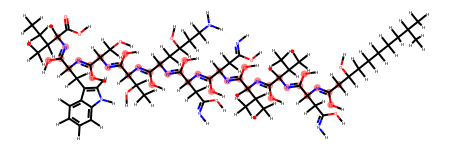

In [72]:
ester = "[C;!R;Z0]~[C;!R;Z0]~[C;!R;Z0]~[C;!R;Z0]~[C;!R;Z0]~[C;!R;Z0]~[C;!R;Z0]~[C;!R](=[O])-[O]-[#6]"
amide = "[C;!R;Z0]~[C;!R;Z0]~[C;!R;Z0]~[C;!R;Z0]~[C;!R;Z0]~[C;!R;Z0]~[C;!R;Z0]~[C;!R](=[O])-[N]-[#6]"
amine = "[C;!R;Z0]~[C;!R;Z0]~[C;!R;Z0]~[C;!R;Z0]~[C;!R;Z0]~[C;!R;Z0]~[C;!R;Z0]~[C;!R]([#1])([#1])-[N]-[#6]"
eter = "[C;!R]~[C;!R;Z0]~[C;!R;Z0]~[C;!R;Z0]~[C;!R;Z0]~[C;!R;Z0]~[C;!R;Z0]~[C;!R]([#1])([#1])-[O]-[#6]"
ester_r = "[C;!R;Z0]~[C;!R;Z0]~[C;!R;Z0]~[C;!R;Z0]~[C;!R;Z0]~[C;!R;Z0]~[C;!R;Z0]~[C;!R]-[O]-[C](=[O])-[#6]"
amide_r = "[C;!R;Z0]~[C;!R;Z0]~[C;!R;Z0]~[C;!R;Z0]~[C;!R;Z0]~[C;!R;Z0]~[C;!R;Z0]~[C;!R]-[N]-[C](=[O])-[#6]"

ester_t = "[C;!R;Z0]~[C;!R;Z0]~[C;!R;Z0]~[C;!R;Z0]~[C;!R;Z0]~[C;!R;Z0]~[C;!R;Z0]~[C;!R](-[O])=[O]-[#6]"
amide_t = "[C;!R;Z0]~[C;!R;Z0]~[C;!R;Z0]~[C;!R;Z0]~[C;!R;Z0]~[C;!R;Z0]~[C;!R;Z0]~[C;!R](-[O])=[N]-[#6]"

ester_r_t = "[C;!R;Z0]~[C;!R;Z0]~[C;!R;Z0]~[C;!R;Z0]~[C;!R;Z0]~[C;!R;Z0]~[C;!R;Z0]~[C;!R]-[O]=[C](-[O])-[#6]"
amide_r_t = "[C;!R;Z0]~[C;!R;Z0]~[C;!R;Z0]~[C;!R;Z0]~[C;!R;Z0]~[C;!R;Z0]~[C;!R;Z0]~[C;!R]-[N]=[C](-[O])-[#6]"

esters = [ester, ester_r, ester_t, ester_r_t]
amides = [amide, amide_r, amide_t, amide_r_t]

smiles = "O=C(O)C(N=C(O)C(N=C(O)C(N=C(O)C(N=C(O)C(N=C(O)C(N=C(O)C(N=C(O)C(N=C(O)C(N=C(O)C(N=C(O)CC(O)CCCCCC(C)C)CC(=N)O)C(C)C)C(C)C)CC(=N)O)CC(=N)O)CC(O)CCN)C(O)C)CO)CC1=CNC=2C=CC=CC21)C(C)CC"
sub = "[C;!R]-[N]=[C](-[O])-[#6]"
mol = Chem.MolFromSmiles(smiles)
mol = Chem.AddHs(mol)
patt = Chem.MolFromSmarts(sub)
print(rdMolDescriptors.CalcNumHeteroatoms(mol))
print(len(list(mol.GetSubstructMatch(patt))))
mol.GetSubstructMatches(patt)
mol

In [73]:
selection_manually_curated["has_amide_linker"] = selection_manually_curated.canonical_smiles.map(lambda smi : substructure_list(smi, amides))

In [74]:
selection_manually_curated["has_ester_linker"] = selection_manually_curated.canonical_smiles.map(lambda smi : substructure_list(smi, esters))

In [75]:
selection_manually_curated["has_eter_linker"] = selection_manually_curated.canonical_smiles.map(lambda smi : substructure(smi, eter))

In [76]:
selection_manually_curated["has_amine_linker"] = selection_manually_curated.canonical_smiles.map(lambda smi : substructure(smi, amine))

# 9-Chain Length Analysis

In [77]:
def chain_len(smiles):
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)
    chain_len = 7
    subunit = "[C;!R;Z0]~"
    smarts = f"[C;!R]~{subunit}[C;!R;Z0]~[C;!R;Z0]~[C;!R;Z0]~[C;!R;Z0]~[C;!R;Z0]~[C;!R]"
    patt = Chem.MolFromSmarts(smarts)
    while len(list(mol.GetSubstructMatch(patt))) > 0:
        subunit+="[C;!R;Z0]~"
        smarts = f"[C;!R]~{subunit}[C;!R;Z0]~[C;!R;Z0]~[C;!R;Z0]~[C;!R;Z0]~[C;!R;Z0]~[C;!R]"
        patt = Chem.MolFromSmarts(smarts)
        chain_len += 1 
    return chain_len


In [78]:
selection_manually_curated["max_chain_len"] = selection_manually_curated.canonical_smiles.map(chain_len)

# 10-Saturation of the chain Analysis

In [83]:
def get_branch(row):
    smiles = row.canonical_smiles
    mol = Chem.MolFromSmiles(smiles)
    length = row.max_chain_len
    if length > 8:
        sub = "[C;!R;Z0]~" * (length-8)
        patt = Chem.MolFromSmarts(f"[C;!R]~{sub}[C;!R;Z0]~[C;!R;Z0]~[C;!R;Z0]~[C;!R;Z0]~[C;!R;Z0]~[C;!R;Z0]~[C;!R]")
    else:
        patt = Chem.MolFromSmarts("[C;!R]~[C;!R;Z0]~[C;!R;Z0]~[C;!R;Z0]~[C;!R;Z0]~[C;!R;Z0]~[C;!R;Z0]~[C;!R]")
    
    matches = mol.GetSubstructMatch(patt)

    branch = 0

    for idx in matches:
        atom = mol.GetAtomWithIdx(idx)
        n = int(len(atom.GetNeighbors()))

        if n > 2:
             branch += 1
    return branch

def get_unsaturation(row):
    smiles = row.canonical_smiles

    coconut_id = row.coconut_id
    
    mol = Chem.MolFromSmiles(smiles)
    length = row.max_chain_len
    if length > 8:
        sub = "[C;!R;Z0]~" * (length-8)
        smarts = f"[C;!R]~{sub}[C;!R;Z0]~[C;!R;Z0]~[C;!R;Z0]~[C;!R;Z0]~[C;!R;Z0]~[C;!R;Z0][C;!R]"
        patt = Chem.MolFromSmarts(smarts)
    else:
        smarts = f"[C;!R]~[C;!R;Z0]~[C;!R;Z0]~[C;!R;Z0]~[C;!R;Z0]~[C;!R;Z0]~[C;!R;Z0][C;!R]"
        patt = Chem.MolFromSmarts(smarts)
    matches = mol.GetSubstructMatch(patt)

    patt_duble = Chem.MolFromSmarts("[C]=[C]")
    patt_triple = Chem.MolFromSmarts("[C]#[C]")
    
    matches_duble = mol.GetSubstructMatches(patt_duble)
    matches_triple = mol.GetSubstructMatches(patt_triple)
    
    uns = 0

    for idx in matches:
        for bond in matches_duble:
            if idx in bond:
                uns+=1
        for bond in matches_triple:
            if idx in bond:
                uns+=1

    return int(uns//2)

def unsaturation_fract(row):
    length = row.max_chain_len
    uns = row.uns
    return (uns*2)/length

In [84]:
selection_manually_curated["uns"] = selection_manually_curated.apply(get_unsaturation, 1) 

In [85]:
selection_manually_curated["unsf"] = selection_manually_curated.apply(unsaturation_fract, 1) 

In [86]:
selection_manually_curated["branches"] = selection_manually_curated.apply(get_branch, 1) 

## TMAP of the subset

In [91]:
selection_manually_curated.max_chain_len.unique()

array([ 8, 12, 10,  9, 13, 15, 14, 16, 11, 18, 20, 22, 17, 24, 19, 23, 21,
       28, 25, 27, 26])

In [92]:
def linker(row):
    if row.has_ester_linker:
        return 1
    elif row.has_amide_linker:
        return 2
    elif row.has_eter_linker:
        return 3
    elif row.has_amine_linker:
        return 4
    else:
        return 0
    
def flag(Rating):
    rating = int(Rating)
    return rating

In [93]:
selection_manually_curated["linker"] = selection_manually_curated.apply(linker,1)

In [94]:
selection_manually_curated["flag"] = selection_manually_curated.Rating.map(flag)

In [95]:
selection_manually_curated["origin"] = selection_manually_curated.origin.map(int)

In [96]:
if not os.path.exists(folder+"coconut_subset_LSHforest"):
    fps = selection_manually_curated["MAP4"].tolist()
    fps_ = []

    for fp in fps:
        fp_ = tm.VectorUint(fp)
        fps_.append(fp_)

    lf_subset = tm.LSHForest(1024, 32)
    lf_subset.batch_add(fps_)

    lf_subset.index()
    lf_subset.store(folder + 'coconut_subset_LSHforest')
else:
    lf_subset = tm.LSHForest(1024, 32)
    lf_subset.restore(folder + 'coconut_subset_LSHforest')

In [97]:
if not os.path.exists(folder+"coconut_subset_tm_layout.pkl"):
    cfg = tm.LayoutConfiguration()

    # config
    cfg.node_size = 1 / 30
    cfg.mmm_repeats = 2
    cfg.sl_extra_scaling_steps = 5
    cfg.k = 20
    cfg.sl_scaling_type = tm.RelativeToAvgLength
    # Compute the layout

    x_, y_, s, t, gp = tm.layout_from_lsh_forest(lf_subset, cfg)
    tm_layout_subset = {"x": list(x_), "y": list(y_), "s" : list(s), "t" : list(t)}
    joblib.dump(tm_layout_subset, folder+"coconut_subset_tm_layout.pkl")
else:
    tm_layout_subset = joblib.load(folder+"coconut_subset_tm_layout.pkl")

In [98]:
tmp = selection_manually_curated.copy()

idx = tmp[tmp["MW"] >= 1000].index
tmp.loc[idx, "MW"] = 1000

idx = tmp[tmp.HBA >= 20].index
tmp.loc[idx, "HBA"] = 20

idx = tmp[tmp.HBD >= 10].index
tmp.loc[idx, "HBD"] = 10

#idx = tmp[tmp.aLogP >= 8].index
#tmp.loc[idx, "aLogP"] = 8

# idx = tmp[tmp.aLogP <= -2].index
# tmp.loc[idx, "aLogP"] = -2

MW = tmp.MW.tolist()
fcsp3 = tmp.fcsp3.tolist()
HBA = tmp.HBA.tolist()
HBD = tmp.HBD.tolist()
alogp = tmp.aLogP.tolist()
alogp_nochain = tmp.alogp_nolipidtail.tolist()
isLipinski = tmp.isLipinski.tolist()
has_lipo_tail = tmp.has_lipo_chain.tolist()
isPeptide = tmp.isPeptide.tolist()
hasSugar = tmp.hasSugar.tolist()
labels = tmp.TMAPlabel.tolist()
SMILES = tmp.SMILES.tolist()
smarts = tmp.smarts.tolist()
origin = tmp.origin.tolist()
flag = tmp.flag.tolist()
linker = tmp.linker.tolist()
chainlen = tmp.max_chain_len.tolist()
deltalogp = tmp.deltaLogP.tolist()
unsat = tmp.uns.tolist()
unsat_f = tmp.unsf.tolist()
branch = tmp.branches.tolist()

In [99]:
min(unsat_f)

0.0

In [100]:
custom_cmap = ListedColormap([ 'lightgray', "magenta"], name="custom")
custom_cmap2 = ListedColormap([ 'limegreen', "lightgray"], name="custom2")
custom_cmap3 = ListedColormap([ "lightgray","cyan", "magenta"], name="custom3")
custom_cmap4 = ListedColormap([ "limegreen", "yellow", "magenta", "tomato", "cyan","lightgray"], name="custom4")
custom_cmap5 = ListedColormap([ 'lightgray',"limegreen", "yellow", "magenta", "tomato", "cyan","pink", "blue", "violet"], name="custom5")

groups = ["0-No", "1-Yes"]
labels_groups, groups = Faerun.create_categories(groups)

groups2 = ["0-other", "1-ester", "2-amide", "3-eter", "4-amine"]
labels_groups2, groups2 = Faerun.create_categories(groups2)

groups4 = ["0-No flag (selected)", "1", "2"]
labels_groups4, groups4 = Faerun.create_categories(groups4)

groups3 = ["0-plants", "1-fungi", "2-bacteria", "3-animals", "4-Homo sapiens", "5-others"]
labels_groups3, groups3 = Faerun.create_categories(groups3)


In [101]:
faerun = Faerun(view="front", coords=False, title='MAP4_curated_subset_COCONUT_TMAP')#, clear_color="#ffffff",)
faerun.add_scatter("MAP4_curated_subset_COCONUT_TMAP",{"x": tm.VectorFloat(tm_layout_subset["x"]), "y": tm.VectorFloat(tm_layout_subset["y"]), "c": [MW, fcsp3, HBA, HBD, alogp, \
                                            alogp_nochain, chainlen, deltalogp, unsat, unsat_f,\
                                            isPeptide, hasSugar, isLipinski, flag, linker, origin],\
                          "labels": labels}, has_legend=True, \
    colormap=["rainbow", "rainbow", "rainbow", "rainbow", "rainbow", "rainbow", "rainbow", "rainbow",custom_cmap5, "rainbow", \
             custom_cmap, custom_cmap, custom_cmap2, custom_cmap3, custom_cmap4,custom_cmap4], \
        point_scale=5, categorical=[False, False, False, False, False, False, False, False, True, False, True, True,True, True, True, True, True,True],\
        series_title=["MW", "Fraction sp3 C", "HBA count", "HBD count", "AlogP", "AlogP nolipid", "Longest Lipidic Chain Length", "DeltaAlogP", \
                      "n.o. unsaturation longest lipidic chain", "fract. unsaturation longest lipidic chain",\
                                             "Peptide", "Sugar", "is Lipinski", "Flag", "Linker Type", "Origin"], \
            max_legend_label=[">=1000", str(round(max(fcsp3),2)), ">=20",\
                              ">=10", str(round(max(alogp),2)), str(round(max(alogp_nochain),2)),str(round(max(chainlen),2)),str(round(max(deltalogp),2)), \
                              str(round(max(unsat),2)),str(round(max(unsat_f),2)),\
                              None, None, None, None , None, None],\
                   min_legend_label=[str(round(min(MW),2)), str(round(min(fcsp3),2)), str(round(min(HBA),2)),\
                              str(round(min(HBD),2)), str(round(min(alogp),2)),str(round(min(alogp_nochain),2)),str(round(min(chainlen),2)),str(round(min(deltalogp),2)),\
                                     str(round(min(unsat),2)),str(round(min(unsat_f),2)),\
                                     None, None, None, None, None, None],\
                    legend_labels=[None, None, None, None, None, None, None, None, None, None,\
                                   labels_groups, labels_groups, labels_groups, labels_groups4, labels_groups2, labels_groups3])

faerun.add_tree("MAP4_curated_subset_COCONUT_TMAP_tree",{"from": tm.VectorUint(tm_layout_subset["s"]), "to": tm.VectorUint(tm_layout_subset["t"])}, point_helper="MAP4_curated_subset_COCONUT_TMAP", color="aaaaaa")
faerun.plot('MAP4_curated_subset_COCONUT_TMAP', template = 'smiles')

/home/alice/Code/lipidatedNPs/MAP4_curated_subset_COCONUT_TMAP.html

# 11-Plot statistics

In [191]:
sns.set_style("whitegrid")

In [192]:
def make_origin_lab(origin):
    if origin <3:
        origins = ["Plants", "Fungi", "Bacteria", "Animals", "Homo\nsapiens", "Marine", "Others"]
        return origins[origin]
    else:
        return "Others"
def make_linker_lab(origin):
    origins = ["Other", "Ester", "Amide", "Ether", "Amine"]
    return origins[origin]

In [193]:
selection_manually_curated["origin_label"] = selection_manually_curated.origin.map(make_origin_lab)
selection_manually_curated["linker_label"] = selection_manually_curated.linker.map(make_linker_lab)

In [194]:
selection_manually_curated["Origin"] = selection_manually_curated.origin_label.astype("category")
selection_manually_curated["Linker Type"] = selection_manually_curated.linker_label.astype("category")

In [195]:
selection_manually_curated["Maximum Chain Length"] = selection_manually_curated["max_chain_len"]
selection_manually_curated["AlogP"] = selection_manually_curated["alogp"].map(float)
selection_manually_curated["AlogP (no lipidic chain)"] = selection_manually_curated["alogp_nolipidtail"]

In [196]:
selection_manually_curated["n.o. unsaturation longest lipidic chain"] = selection_manually_curated["uns"]
selection_manually_curated["fract unsaturation longest lipidic chain"] = selection_manually_curated["unsf"]

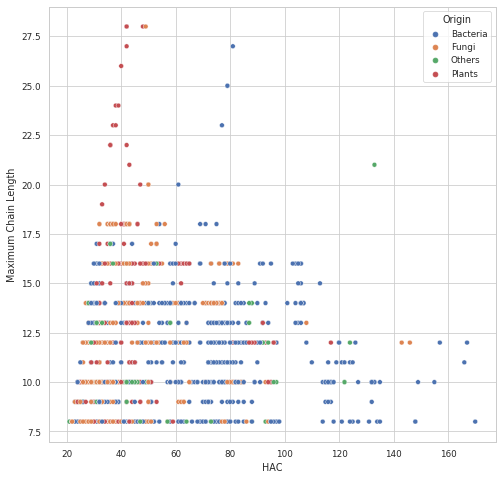

In [198]:
data = selection_manually_curated.query("flag==0")
sns.scatterplot(data=data, x="HAC", y="Maximum Chain Length", hue="Origin")
sns.set(rc={'figure.figsize':(5,5)})
plt.savefig("plots/maxchainlength_VS_HAC.png", dpi=300)

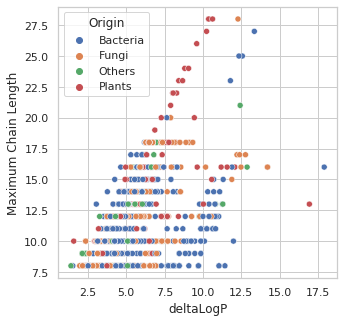

In [208]:
data = selection_manually_curated.query("flag==0")
sns.set_style("whitegrid")
sns.scatterplot(data=data, x="deltaLogP", y="Maximum Chain Length", hue="Origin")
plt.savefig("plots/maxchainlength_VS_deltaLogP.png", dpi=300)

In [200]:
forexcel = selection_manually_curated.query("flag==0")[["coconut_id", "SMILES", "Origin", "Maximum Chain Length", "AlogP", "AlogP (no lipidic chain)",\
                                                        "n.o. unsaturation longest lipidic chain", "fract unsaturation longest lipidic chain", "Linker Type"]].copy()
PandasTools.AddMoleculeColumnToFrame(forexcel, smilesCol='SMILES', molCol='ROMol', includeFingerprints=False)
forexcel.Origin = forexcel.Origin.astype(str)
forexcel["Linker Type"] = forexcel["Linker Type"].astype(str)
PandasTools.SaveXlsxFromFrame(forexcel, "data/plot_data.xlsx", molCol='ROMol', size=(300, 300))

In [201]:
forplot = selection_manually_curated.query("flag==0")[["Origin", "Maximum Chain Length", "AlogP", "AlogP (no lipidic chain)", "Linker Type",\
                                                       "n.o. unsaturation longest lipidic chain", "fract unsaturation longest lipidic chain"]]

In [202]:
forplot_ = selection_manually_curated.query("flag==0 and uns >0")[["Origin", "Maximum Chain Length", "AlogP", "AlogP (no lipidic chain)", "Linker Type",\
                                                       "n.o. unsaturation longest lipidic chain", "fract unsaturation longest lipidic chain"]]

In [203]:
min(forplot_["fract unsaturation longest lipidic chain"].tolist())

0.08

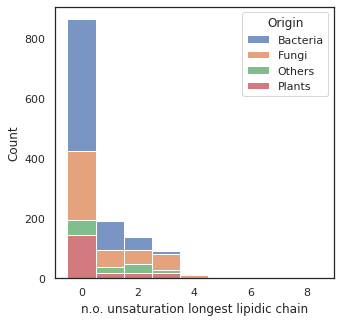

In [220]:
sns.set_theme()
sns.set_style("white")
sns.histplot(data=forplot, x="n.o. unsaturation longest lipidic chain", hue="Origin", discrete=True, log_scale=(False,False), multiple="stack")
plt.savefig("plots/hist_unsaturation_count.png", dpi=300)

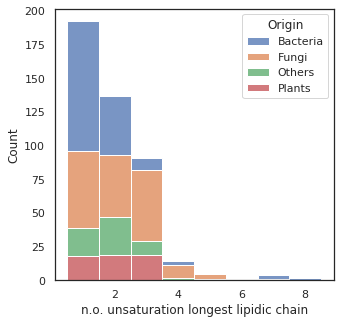

In [221]:
sns.histplot(data=forplot_ , x="n.o. unsaturation longest lipidic chain", hue="Origin", discrete=True, log_scale=(False,False), multiple="stack")
sns.set_theme()
sns.set_style("white")
plt.savefig("plots/hist_at_least_one_unsaturation_count.png", dpi=300)

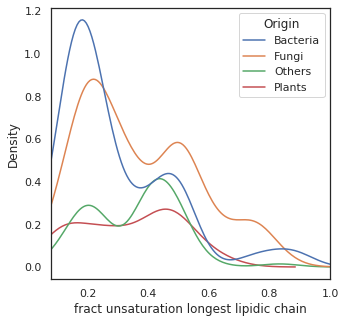

In [222]:
sns.kdeplot(data=forplot_, x="fract unsaturation longest lipidic chain", hue="Origin")#, discrete=True, log_scale=(False,False), multiple="stack")
plt.xlim(0.08,1.0)
sns.set_theme()
sns.set_style("white")
plt.savefig("plots/distr_at_least_one_unsaturation_fract.png", dpi=300)

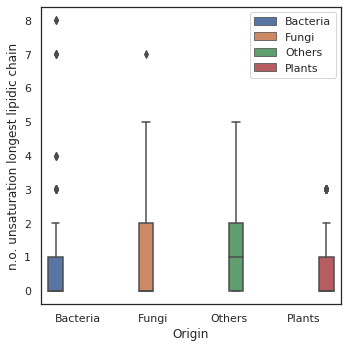

In [223]:
sns.boxplot(data=forplot, y="n.o. unsaturation longest lipidic chain", hue="Origin", x="Origin")
plt.tight_layout()
sns.set_theme()
sns.set_style("white")
plt.legend(loc="upper right")#,bbox_to_anchor=(1.25, 0.5))
plt.savefig("plots/count_uns_origin.svg", dpi=300)

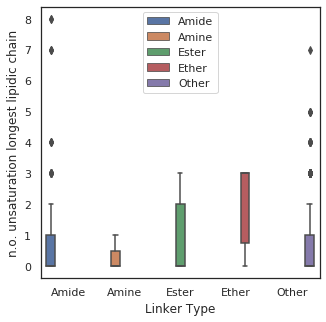

In [225]:
sns.boxplot(data=forplot, y="n.o. unsaturation longest lipidic chain", hue="Linker Type", x="Linker Type")
sns.set_theme()
sns.set_style("white")
plt.legend()
plt.savefig("plots/count_uns_linker.svg", dpi=300)

In [123]:
def is_categorical(array_like):
    return array_like.dtype.name == 'category'

x:0, Maximum Chain Length. y: 0, Maximum Chain Length
x:0, Maximum Chain Length. y: 1, AlogP
x:0, Maximum Chain Length. y: 2, AlogP (no lipidic chain)
x:0, Maximum Chain Length. y: 3, Linker Type
x:1, AlogP. y: 0, Maximum Chain Length
x:1, AlogP. y: 1, AlogP
x:1, AlogP. y: 2, AlogP (no lipidic chain)
x:1, AlogP. y: 3, Linker Type
x:2, AlogP (no lipidic chain). y: 0, Maximum Chain Length
x:2, AlogP (no lipidic chain). y: 1, AlogP
x:2, AlogP (no lipidic chain). y: 2, AlogP (no lipidic chain)
x:2, AlogP (no lipidic chain). y: 3, Linker Type
x:3, Linker Type. y: 0, Maximum Chain Length
x:3, Linker Type. y: 1, AlogP
x:3, Linker Type. y: 2, AlogP (no lipidic chain)
x:3, Linker Type. y: 3, Linker Type


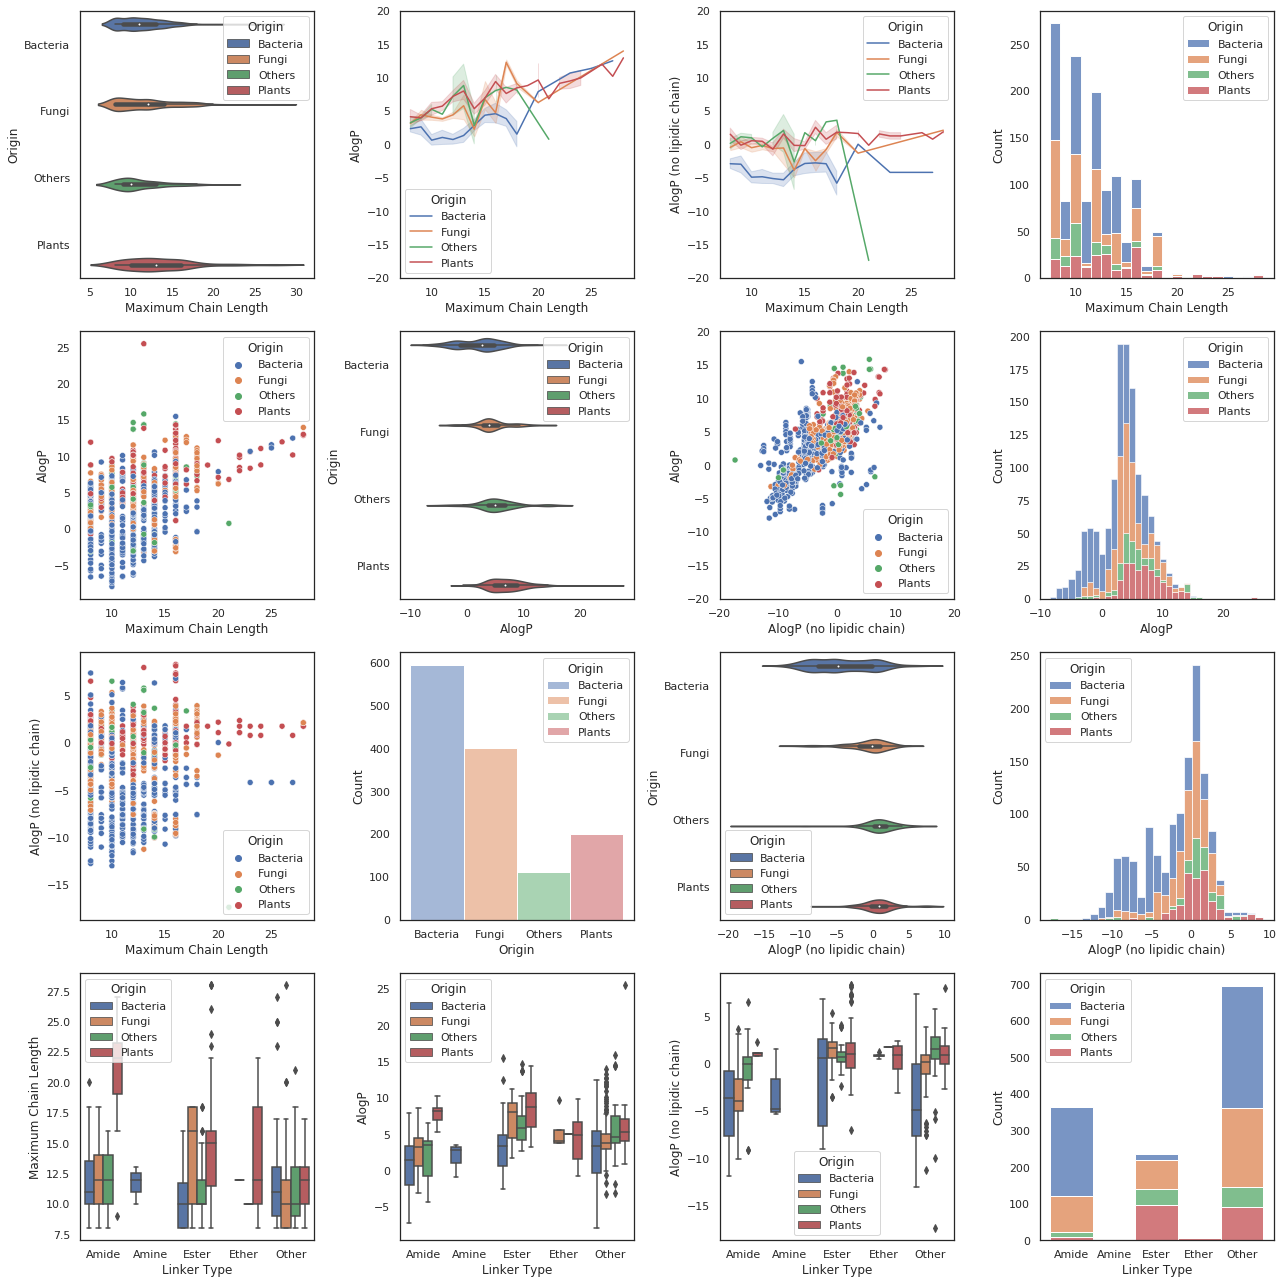

In [226]:
attributs = ["Maximum Chain Length", "AlogP", "AlogP (no lipidic chain)", "Linker Type"]
fig,axs = plt.subplots(len(attributs),len(attributs), figsize=(18,18))
for i in range(len(attributs)):
    for j in range(len(attributs)):
        ax = axs[i,j]
        print(f"x:{i}, {attributs[i]}. y: {j}, {attributs[j]}")
        
        # diagonal
        if i == j:
            if is_categorical(forplot[attributs[i]]) == False:
                sns.violinplot(data=forplot, x=attributs[i], ax=ax, hue="Origin", y="Origin")
            else:
                sns.histplot(data=forplot, x=attributs[i], ax=ax, hue="Origin", discrete=True, log_scale=(False,False), multiple="stack")
        else:
            if i == 0 and (j == 1 or j == 2):
                sns.lineplot(data=forplot, x=attributs[i], y=attributs[j], ax=ax, hue="Origin")
                ax.set_ylim(-20,20)
            elif is_categorical(forplot[attributs[i]]) == False and is_categorical(forplot[attributs[j]]) == False:
                if i == 2 and j == 1:
                    sns.histplot(data=forplot, x="Origin", ax=ax, hue="Origin")
                else:
                    sns.scatterplot(data=forplot, x=attributs[j], y=attributs[i], ax=ax, hue="Origin")
                    if i == 1 and j == 2:
                        ax.set_ylim(-20,20)
                        ax.set_xlim(-20,20)
                
            elif is_categorical(forplot[attributs[i]]) == True and is_categorical(forplot[attributs[j]]) == False:
                sns.boxplot(data=forplot, x=attributs[i], y=attributs[j], ax=ax, hue="Origin")
            else:
                sns.histplot(data=forplot, x=attributs[i], ax=ax, hue="Origin", discrete=True, log_scale=(False,False), multiple="stack")
plt.tight_layout()
plt.savefig("plots/selected_lipidatedNP.svg")

In [125]:
forplot.Origin.value_counts()

Bacteria         595
Fungi            400
Plants           201
Others            75
Animals           19
Marine            16
Homo\nsapiens      2
Name: Origin, dtype: int64

In [126]:
forplot["Linker Type"].value_counts()

Other    696
Amide    364
Ester    235
Ether     10
Amine      3
Name: Linker Type, dtype: int64

In [127]:
forplot[forplot['Linker Type']=='Ester']["Maximum Chain Length"].mean()

13.225531914893617

In [128]:
forplot[forplot['Linker Type']=='Ester']["Maximum Chain Length"].median()

12.0

## find series 

In [129]:
def is_in_series(smiles_no_tail, series):
    if smiles_no_tail in series:
        return 1
    else:
        return 0

In [130]:
smiles_no_tail_subset = selection_manually_curated.query("Rating==0")["smiles_no_tail"].to_list()
ids_subset = selection_manually_curated.query("Rating==0").index.to_list()

In [131]:
coconut["has_non_lipCoreSubset"] = coconut.smiles_no_tail.map(lambda smi: is_in_series(smi, smiles_no_tail_subset))

In [132]:
coconut["is_chosen"] = coconut.coconut_id.map(lambda smi: is_in_series(smi, ids_subset))

In [133]:
coconut_ = coconut.query("has_non_lipCoreSubset == 1")

In [134]:
series = coconut_.groupby("smiles_no_tail").count()
smiles_series = series.query("inchi > 1").index.to_list()
smiles_series = list(set(smiles_series))

In [135]:
len(smiles_series)

317

In [136]:
def is_in_smiles_series(smiles_no_tail, series=smiles_series):
    if smiles_no_tail in series:
        return smiles_series.index(smiles_no_tail)
    else:
        return 0

In [137]:
coconut_["is_in_series"]= coconut_.smiles_no_tail.map(is_in_smiles_series)

/home/alice/miniconda3/envs/aipep/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [138]:
series_coconut = coconut_.query("is_in_series != -1").copy()

In [139]:
len(series_coconut.query("is_chosen==1"))

1308

In [140]:
len(series_coconut)

1663

In [141]:
series_coconut_sorted = series_coconut.sort_values("is_in_series")

In [142]:
series_coconut_sorted

,coconut_id,inchi,inchikey,SMILES,sugar_free_smiles,molecular_formula,molecular_weight,citationDOI,textTaxa,name,...,has_sterol,n_rings_nosugar,mw_nolipidtail_nosugar,smarts,is_terminal,alogp_nolipidtail,smiles_no_tail,has_non_lipCoreSubset,is_chosen,is_in_series
17065,CNP0017588,InChI=1S/C34H48O12/c1-9-10-11-12-13-14-27(38)4...,CSVDSXWAISTBNQ-UHFFFAOYSA-N,O=C(OC1C=CC2(C)C(OC(=O)C)CC(OC(=O)CCCCCCC)C(=C...,O=C(OC1C=CC2(C)C(OC(=O)C)CC(OC(=O)CCCCCCC)C(=C...,C34H48O12,648.739035805262,"[Iwagawa,J.Nat.Prod.,68,(2005),31]","[Briareum sp., marine]",Briarlide L,...,0,4,549.197201,2,1,0.98030,[H]OC1(C([H])([H])[H])C([H])(OC(=O)C([H])([H])...,1,1,0
212029,CNP0249871,InChI=1S/C51H82N8O17/c1-3-4-5-6-7-8-9-10-11-12...,GYMNBBQUGVYSCX-UHFFFAOYSA-N,O=C(N)CCC1NC(=O)C(NC(=O)C2N(C(=O)C(NC(=O)C(NC(...,O=C(N)CCC1NC(=O)C(NC(=O)C2N(C(=O)C(NC(=O)C(NC(...,C51H82N8O17,1079.2421819748693,"[Strobel,J.Nat.Prod.,67,(2004),257]","[Cryptosporiopsis cf. quercina, fungi]",Cryptocandin,...,0,4,867.337217,2,1,-8.74620,[H]Oc1c([H])c([H])c(C([H])(O[H])C([H])(O[H])C2...,1,1,0
213499,CNP0251448,InChI=1S/C36H50O14/c1-10-11-12-13-14-15-26(41)...,SDDBDSSLCGRGSD-UHFFFAOYSA-N,O=C(OC1C=CC2(C)C(OC(=O)C)C(OC(=O)C)C(OC(=O)CCC...,O=C(OC1C=CC2(C)C(OC(=O)C)C(OC(=O)C)C(OC(=O)CCC...,C36H50O14,706.7751989616282,"[Iwagawa,J.Nat.Prod.,68,(2005),31]","[Briareum sp., marine]",Briarlide I,...,0,4,607.202681,2,1,0.52190,[H]OC1(C([H])([H])[H])C([H])(OC(=O)C([H])([H])...,1,1,0
213928,CNP0251904,InChI=1S/C28H37NO7/c1-6-7-8-9-10-11-19(30)15(3...,SUQZYGYUFVUJGV-UHFFFAOYSA-N,O=C(O)C=1C(O)=C(C2=C3C1OC4N(C(=O)C(C(=O)CCCCC=...,O=C(O)C=1C(O)=C(C2=C3C1OC4N(C(=O)C(C(=O)CCCCC=...,C28H37NO7,499.59695070163946,"[NA, 10.1021/ol051695h]","[fungi, Penicillium citrinum]",Perinadine A,...,0,4,402.155277,2,1,2.27492,[H]OC(=O)c1c(O[H])c(C([H])([H])[H])c2c3c1OC1([...,1,1,0
214313,CNP0252311,InChI=1S/C38H57NO10/c1-2-3-4-5-6-7-8-9-10-11-1...,ALECKIMNHVMLRG-UHFFFAOYSA-N,O=C(OCC1OC(OC2C(O)C=C3CCN4CC5=CC=6OCOC6C=C5C2C...,OC1C=C2CCN3CC4=CC=5OCOC5C=C4C(C1O)C23,C38H57NO10,687.8613395287432,"[Ghosal,Phytochem.,24,(1985),2703]","[Artemisia juncea, Hesperocyparis arizonica, p...",Lycoriside,...,0,5,287.115758,2,1,-1.33570,[H]OC1([H])C([H])=C2C([H])([H])C([H])([H])N3C(...,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197389,CNP0234241,InChI=1S/C89H99Cl2N9O33/c1-4-34(2)9-7-5-6-8-10...,KSPOYQQCANXEDC-UHFFFAOYSA-N,O=C(O)C1NC(=O)C2NC(=O)C(NC(=O)C3NC(=O)C4NC(=O)...,O=C(O)C1NC(=O)C2NC(=O)C(NC(=O)C3NC(=O)C4NC(=O)...,C89H99Cl2N9O33,1893.6881960723658,"[10.1021/ja00329a044, NA]","[bacteria, Actinoplanes teichomyceticus]",Teicoplanin A2-4,...,0,13,1197.219813,2,1,-2.43650,[H]OC(=O)C1([H])c2c([H])c(O[H])c([H])c(OC3([H]...,1,1,316
191029,CNP0227427,InChI=1S/C88H97Cl2N9O33/c1-3-4-5-6-7-8-9-10-60...,BJNLLBUOHPVGFT-UHFFFAOYSA-N,O=C(O)C1NC(=O)C2NC(=O)C(NC(=O)C3NC(=O)C4NC(=O)...,O=C(O)C1NC(=O)C2NC(=O)C(NC(=O)C3NC(=O)C4NC(=O)...,C88H97Cl2N9O33,1879.6615786679263,"[10.1021/ja00329a044, NA]","[bacteria, plants, Actinoplanes teichomyceticus]",Teicoplanin,...,0,13,1197.219813,2,1,-2.43650,[H]OC(=O)C1([H])c2c([H])c(O[H])c([H])c(OC3([H]...,1,1,316
294209,CNP0337477,InChI=1S/C88H97Cl2N9O33/c1-33(2)8-6-4-5-7-9-60...,GHOXVFYORXUCPY-UHFFFAOYSA-N,O=C(O)C1NC(=O)C2NC(=O)C(NC(=O)C3NC(=O)C4NC(=O)...,O=C(O)C1NC(=O)C2NC(=O)C(NC(=O)C3NC(=O)C4NC(=O)...,C88H97Cl2N9O33,1879.6615786679263,"[10.1021/ja00329a044, NA, 25147913, 11833531, ...","[bacteria, Actinoplanes teichomyceticus]",Teicoplanin A2-2,...,0,13,1197.219813,2,1,-2.43650,[H]OC(=O)C1([H])c2c([H])c(O[H])c([H])c(OC3([H]...,1,1,316
308827,CNP0353127,InChI=1S/C88H93Cl2N9O33/c1-3-4-5-6-7-8-9-10-60...,QUDLVMPJKSJEDL-UHFFFAOYSA-N,O=C(O)C1NC(=O)C2NC(=O)C(NC(=O)C3NC(=O)C4NC(=O)...,O=C(O)C1NC(=O)C2NC(=O)C(NC(=O)C3NC(=O)C4NC(=O)...,C88H93Cl2N9O33,1875.6298156526232,"[NA, 10.7164/antibiotics.50.180]","[bacteria, Actinoplanes teichomyceticus]",Teicoplanin Product I,...,0,13,1197.219813,2,1,-2.43650,[H]OC(=O)C1([H])c2c([H])c(O[H])c([H])c(OC3([H]...,1,1,316


In [143]:
series_coconut_ = series_coconut_sorted[["coconut_id", "canonical_smiles", "is_in_series", "textTaxa", "name", "is_chosen"]]
PandasTools.AddMoleculeColumnToFrame(series_coconut_, smilesCol='canonical_smiles', molCol='ROMol', includeFingerprints=False)
series_coconut.Origin = series_coconut_.textTaxa.astype(str)
PandasTools.SaveXlsxFromFrame(series_coconut_, "data/series.xlsx", molCol='ROMol', size=(300, 300))

/home/alice/miniconda3/envs/aipep/lib/python3.6/site-packages/rdkit/Chem/PandasTools.py:416: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[molCol] = frame[smilesCol].map(Chem.MolFromSmiles)
/home/alice/miniconda3/envs/aipep/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  This is separate from the ipykernel package so we can avoid doing imports until


In [144]:
series_coconut.columns

Index(['coconut_id', 'inchi', 'inchikey', 'SMILES', 'sugar_free_smiles',
       'molecular_formula', 'molecular_weight', 'citationDOI', 'textTaxa',
       'name', 'synonyms', 'NPL_score', 'number_of_carbons',
       'number_of_nitrogens', 'number_of_oxygens', 'number_of_rings',
       'total_atom_number', 'bond_count', 'found_in_databases',
       'murko_framework', 'alogp', 'apol', 'topoPSA', 'ID', 'ROMol',
       'has_source', 'canonical_smiles', 'simple_tax', 'MAP4', 'fcsp3', 'HBA',
       'HBD', 'aLogP', 'MW', 'isLipinski', 'isPeptide', 'hasSugar',
       'TMAPlabel', 'origin', 'has_lipo_chain', 'has_ring', 'has_sterol',
       'n_rings_nosugar', 'mw_nolipidtail_nosugar', 'smarts', 'is_terminal',
       'alogp_nolipidtail', 'smiles_no_tail', 'has_non_lipCoreSubset',
       'is_chosen', 'is_in_series'],
      dtype='object')